# Binary System

This notebook demonstrates the setup and visualization of a simple binary star system. We construct two mesh-based stellar models, combine them into a binary system, and visualize their projected geometry.
We can then generate spectra and lightcurves for the system.

In [1]:
from spice.models.binary import Binary, add_orbit, evaluate_orbit_at_times
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_view import get_mesh_view
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
import jax.numpy as jnp
%matplotlib inline

Let's generate a helper function that constructs a simple icosphere model and rescale the bodies and temperatures.

**Note**: The orbit resolution points parameter determines how finely the binary orbit is sampled when generating the positions and velocities of the stars along their orbit. By making this a parameter, we can control the temporal resolution of the simulated orbit, which is important for accurate lightcurve and radial velocity modeling, especially for systems with short periods or rapid changes. The fact it has to be defined at the binary system construction level is just a JAX-based optimization.

In [2]:
def default_icosphere(radius=1, teff=5700):
    return get_mesh_view(IcosphereModel.construct(1000, radius, 1., [teff], ['teff']), jnp.array([0., 1., 0.]))

body1 = default_icosphere()
body2 = default_icosphere(0.5, 4000)
binary = Binary.from_bodies(body1, body2)

binary = add_orbit(binary,
                   P = 1.,
                   ecc = 0.,
                   T = 0.,
                   i = 0.,
                   omega = 0.,
                   Omega = 0.,
                   mean_anomaly = 10,
                   reference_time = 0.,
                   vgamma = 0.,
                   orbit_resolution_points = 20)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


Let's sample the orbit around eclipse times (these are precomputed and fine-tuned to this particular system.)

In [3]:
binary.n_neighbours1, binary.n_neighbours2

(Array(5, dtype=int32, weak_type=True), Array(33, dtype=int32, weak_type=True))

In [4]:
times = jnp.linspace(0.15706372, 0.1598338, 20)
pb1, pb2 = evaluate_orbit_at_times(binary, times)

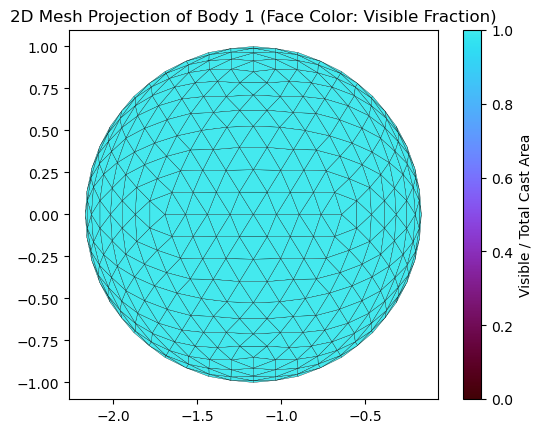

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cmasher as cmr

from matplotlib.collections import PolyCollection
import numpy as np
import matplotlib as mpl

fig, ax = plt.subplots()

# Precompute static mesh geometry (vertices and faces)
vertices_2d = pb1[0].cast_vertices  # (n_vertices, 2)
faces = pb1[0].faces.astype(int)    # (n_faces, 3)

# For each frame, only show faces with mus > 0 (visible)
def get_visible_polygons_and_colors(pb, i):
    visible_mask = np.array(pb[i].mus > 0)
    visible_faces = faces[visible_mask]
    polygons = [vertices_2d[tri] for tri in visible_faces]
    face_colors = np.array(pb[i].visible_cast_areas)[visible_mask] / np.array(pb[i].cast_areas)[visible_mask]
    return polygons, face_colors

# For colorbar normalization, get global min/max over all frames
all_colors = np.concatenate([
    np.array(pb1[i].visible_cast_areas)[np.array(pb1[i].mus > 0)] / np.array(pb1[i].cast_areas)[np.array(pb1[i].mus > 0)]
    for i in range(len(times))
])
vmin, vmax = all_colors.min(), all_colors.max()

# Set up colormap and normalization
cmap = cmr.gem
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# Initialize with frame 0
polygons, face_colors = get_visible_polygons_and_colors(pb1, 0)
face_colors_mapped = cmap(norm(face_colors))
coll = PolyCollection(polygons, facecolors=face_colors_mapped, edgecolor='k', linewidth=0.2)
ax.add_collection(coll)

ax.set_aspect('equal')
ax.set_xlim(vertices_2d[:, 0].min() - 0.1, vertices_2d[:, 0].max() + 0.1)
ax.set_ylim(vertices_2d[:, 1].min() - 0.1, vertices_2d[:, 1].max() + 0.1)

# Create a ScalarMappable for the colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Visible / Total Cast Area')
ax.set_title("2D Mesh Projection of Body 1 (Face Color: Visible Fraction)")

def update(i):
    polygons, face_colors = get_visible_polygons_and_colors(pb1, i)
    face_colors_mapped = cmap(norm(face_colors))
    coll.set_verts(polygons)
    coll.set_facecolor(face_colors_mapped)
    return coll,

ani = FuncAnimation(fig, update, frames=len(times), interval=5, blit=True)
plt.show()
ani.save('occlusion_mesh.gif')

## Spectrum for the binary star

The spectra have to be calculated separately for both system components and then combined.

In [6]:
bb = Blackbody()

wavelengths = jnp.log10(jnp.linspace(1, 30000, 10000))
fluxes1 = jnp.array([simulate_observed_flux(bb.intensity, _pb1, wavelengths) for _pb1 in pb1])
fluxes2 = jnp.array([simulate_observed_flux(bb.intensity, _pb2, wavelengths) for _pb2 in pb2])
flux_binary = jnp.array([_f1 + _f2 for _f1, _f2 in zip(fluxes1, fluxes2)])

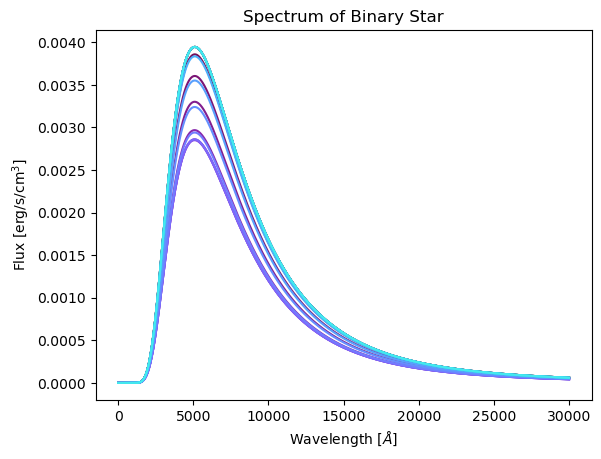

In [7]:
# Plot each timestep with a color corresponding to its index
cmap = plt.get_cmap('cmr.gem')
num_steps = len(flux_binary)
colors = [cmap(i / (num_steps - 1)) for i in range(num_steps)]

for i, f in enumerate(flux_binary):
    plt.plot(10**wavelengths, f[:, 0], color=colors[i])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_steps-1))
plt.gca().set_xlabel('Wavelength [$\AA$]');
plt.gca().set_ylabel('Flux [erg/s/cm$^3$]');
plt.gca().set_title('Spectrum of Binary Star');

If we have the spectra, we can calculate the photometric time series as well!

In [8]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import GaiaG, GaiaBP, GaiaRP, Bolometric

bol = Bolometric()

bol_lum = jnp.array([AB_passband_luminosity(bol, 10**wavelengths, _spec[:, 0]) for _spec in flux_binary])

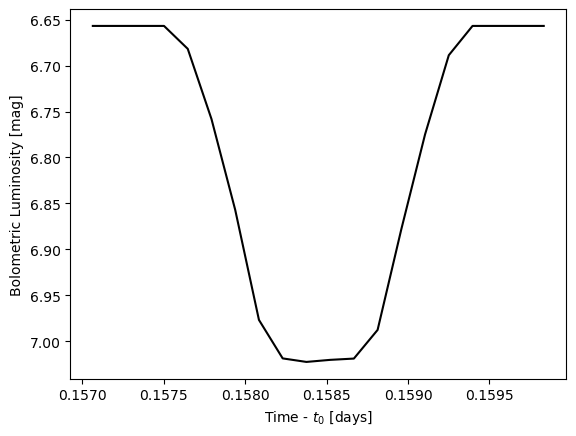

In [9]:
plt.plot(times, bol_lum, color='black');
plt.gca().set_xlabel('Time - $t_0$ [days]');
plt.gca().set_ylabel('Bolometric Luminosity [mag]');
plt.gca().invert_yaxis();